In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load RFMS features with labels
rfms = pd.read_csv('../data/processed/rfms_with_labels.csv')

# Display the dataset
rfms.head()


,CustomerId,recency,frequency,monetary,severity,risk_label
0,CustomerId_1,83,1,-10000.0,0.0,0
1,CustomerId_10,83,1,-10000.0,0.0,0
2,CustomerId_1001,89,5,20000.0,0.0,0
3,CustomerId_1002,25,11,4225.0,0.0,1
4,CustomerId_1003,11,6,20000.0,0.0,1


In [3]:
# Define features (X) and target (y)
X = rfms[['recency', 'frequency', 'monetary', 'severity']]  # Use RFMS features
y = rfms['risk_label']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


Training Set Shape: (2619, 4)
Testing Set Shape: (1123, 4)


In [4]:
# Train Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_logreg = log_reg.predict(X_test)
y_prob_logreg = log_reg.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Logistic Regression Metrics:")
print(classification_report(y_test, y_pred_logreg))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_logreg))


Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78       483
           1       0.86      0.75      0.80       640

    accuracy                           0.79      1123
   macro avg       0.79      0.80      0.79      1123
weighted avg       0.80      0.79      0.79      1123

ROC-AUC: 0.8941996635610767


c:\Users\hp\Documents\BatiBank-CreditRisk\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
# Train Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Random Forest Metrics:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       483
           1       1.00      1.00      1.00       640

    accuracy                           1.00      1123
   macro avg       1.00      1.00      1.00      1123
weighted avg       1.00      1.00      1.00      1123

ROC-AUC: 1.0


In [6]:
# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

# Predict with the best model
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
y_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best ROC-AUC: 0.999983946230575


In [7]:
# Evaluate Logistic Regression
metrics_logreg = {
    'Accuracy': accuracy_score(y_test, y_pred_logreg),
    'Precision': precision_score(y_test, y_pred_logreg),
    'Recall': recall_score(y_test, y_pred_logreg),
    'F1 Score': f1_score(y_test, y_pred_logreg),
    'ROC-AUC': roc_auc_score(y_test, y_prob_logreg)
}

# Evaluate Best Random Forest
metrics_rf = {
    'Accuracy': accuracy_score(y_test, y_pred_best_rf),
    'Precision': precision_score(y_test, y_pred_best_rf),
    'Recall': recall_score(y_test, y_pred_best_rf),
    'F1 Score': f1_score(y_test, y_pred_best_rf),
    'ROC-AUC': roc_auc_score(y_test, y_prob_best_rf)
}

# Display metrics
metrics_df = pd.DataFrame([metrics_logreg, metrics_rf], index=['Logistic Regression', 'Random Forest'])
print("Model Performance Comparison:")
print(metrics_df)


Model Performance Comparison:
                     Accuracy  Precision  Recall  F1 Score  ROC-AUC
Logistic Regression  0.789849   0.863309    0.75  0.802676   0.8942
Random Forest        1.000000   1.000000    1.00  1.000000   1.0000


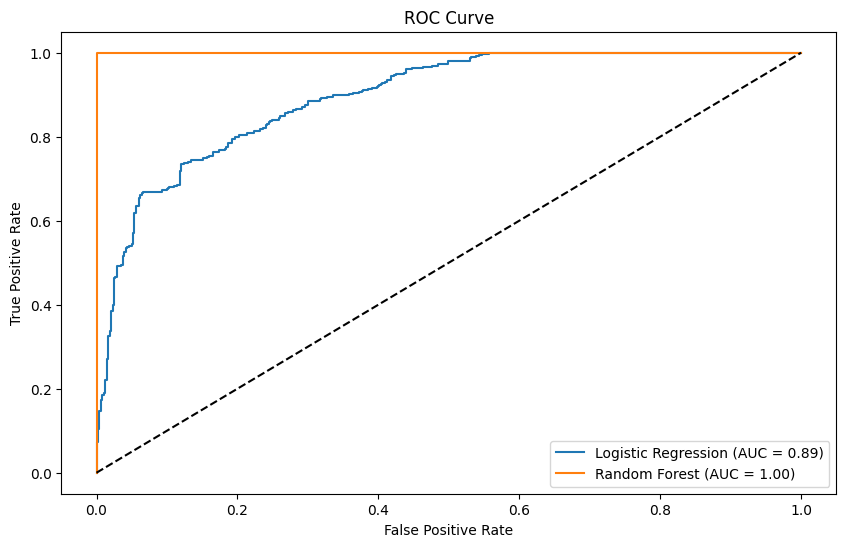

In [8]:
# Compute ROC curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_best_rf)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_logreg)))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_best_rf)))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [9]:
import joblib

# Save the best Random Forest model
joblib.dump(best_rf, '../models/best_random_forest.pkl')

# Save the Logistic Regression model
joblib.dump(log_reg, '../models/logistic_regression.pkl')

print("Models saved successfully.")


Models saved successfully.
